In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import rotate
from multiprocess import Pool

import pandas

from cell_utilities import *

Setting environment for Gordon


No vtk


In [2]:
stack = 'MD589'

In [3]:
DETECTED_CELLS_DIR = '/home/yuncong/csd395/CSHL_cells_v2/detected_cells/'
PROCESSED_CELLS_DIR = '/home/yuncong/csd395/CSHL_cells_v2/processed_cells/'

In [4]:
def load_cell_list_data(what):
    if what == 'address':
        fn = 'cell_addresses.bp'
    elif what == 'mask_aligned_padded':
        fn = 'cells_aligned_padded.bp'
    elif what == 'mask_aligned_padded_horizontal':
        fn = 'cells_h_aligned_padded.bp'
    elif what == 'mask_aligned_padded_vertical':
        fn = 'cells_v_aligned_padded.bp'
    elif what == 'mask_aligned_padded_diagonal':
        fn = 'cells_d_aligned_padded.bp'
    elif what == 'largest30p_indices':
        fn = 'largest30p_indices.bp'
    elif what == 'embedding':
        fn = 'embeddings_normalized_largest30p_nystromSample100.bp'
        
    return bp.unpack_ndarray_file(os.path.join(PROCESSED_CELLS_DIR, fn))

In [5]:
def load_cell_data(what, stack, sections):
    
    sections_to_filenames = metadata_cache['sections_to_filenames'][stack]
    
    if what == 'orientation':
        fn_template = '%(fn)s_blobOrientations.bp'
    elif what == 'major':
        fn_template = '%(fn)s_blobMajorAxisLen.bp'
    elif what == 'minor':
        fn_template = '%(fn)s_blobMinorAxisLen.bp'
    elif what == 'mask_center':
        fn_template = '%(fn)s_blobMaskCenters.bp'
    elif what == 'mask':
        fn_template = '%(fn)s_blobMasks.hdf'
    elif what == 'centroid':
        fn_template = '%(fn)s_blobCentroids.bp'
    elif what == 'contours':
        fn_template = '%(fn)s_blobContours.hdf'
    elif what == 'image':
        fn_template = '%(fn)s_image.jpg'
    else:
        raise Exception('Not recognized.')

    data = {}
    for sec in sections:
        fn = sections_to_filenames[sec]
        fp = os.path.join(DETECTED_CELLS_DIR, stack, '%(fn)s', fn_template) % {'fn': fn}
        if fp.endswith('bp'):
            data[sec] = bp.unpack_ndarray_file(fp)
        elif fp.endswith('jpg'):
            data[sec] = imread(fp)
        elif fp.endswith('hdf'):
            data[sec] = pandas.read_hdf(fp)
        else:
            raise Exception('Not recognized.')
            
    return data

In [289]:
def normalize_angle(a):
    """
    Force angle into -pi/2 to pi/2.
    """
    if a > np.pi/2:
        a = a - np.pi
    elif a < -np.pi/2:
        a = a + np.pi
    return a

In [287]:
cell_orientations_per_section = load_cell_data('orientation', stack=stack, sections=[192,242])
cell_orientations_per_section = {sec: np.array(map(normalize_angle, data)) for sec, data in cell_orientations_per_section.iteritems()}

In [6]:
cell_centroids_per_section = load_cell_data('centroid', stack=stack, sections=[192,242])

In [7]:
cell_numbers_per_section = {sec: x.shape[0] for sec, x in cell_centroids_per_section.iteritems()}

In [8]:
cell_addresses = load_cell_list_data('address')

In [9]:
cell_masks_aligned_padded = load_cell_list_data('mask_aligned_padded')

In [10]:
cell_masks_aligned_padded_horizontal = load_cell_list_data('mask_aligned_padded_horizontal')
cell_masks_aligned_padded_vertical = load_cell_list_data('mask_aligned_padded_vertical')
cell_masks_aligned_padded_diagonal = load_cell_list_data('mask_aligned_padded_diagonal')

In [10]:
# cell_masks_per_section = load_cell_data('mask', stack, [192, 242])
# cell_sizes_per_section = {sec: [np.count_nonzero(msk) for msk in masks] for sec, masks in cell_masks_per_section.iteritems()}

In [11]:
def group_according_to_address(x, addresses):
    
    x_per_section = defaultdict(dict)

    for (sec, secwise_idx), xi in zip(addresses, x):
        x_per_section[sec][secwise_idx] = xi

    x_per_section.default_factory = None
    
    return x_per_section

cell_masks_aligned_padded_per_section = group_according_to_address(cell_masks_aligned_padded, cell_addresses)
cell_masks_aligned_padded_horizontal_per_section = group_according_to_address(cell_masks_aligned_padded_horizontal, cell_addresses)
cell_masks_aligned_padded_vertical_per_section = group_according_to_address(cell_masks_aligned_padded_vertical, cell_addresses)
cell_masks_aligned_padded_diagonal_per_section = group_according_to_address(cell_masks_aligned_padded_diagonal, cell_addresses)

def flatten_mask_dict(cell_masks_aligned_padded_per_section):
    cell_masks_aligned_padded_flattened_per_section = {sec: {secwise_idx: mask.flatten() 
                                                         for secwise_idx, mask in masks.iteritems()}
                                                   for sec, masks in cell_masks_aligned_padded_per_section.iteritems()}
    return cell_masks_aligned_padded_flattened_per_section

cell_masks_aligned_padded_flattened_per_section = flatten_mask_dict(cell_masks_aligned_padded_per_section)
cell_masks_aligned_padded_horizontal_flattened_per_section = flatten_mask_dict(cell_masks_aligned_padded_horizontal_per_section)
cell_masks_aligned_padded_vertical_flattened_per_section = flatten_mask_dict(cell_masks_aligned_padded_vertical_per_section)
cell_masks_aligned_padded_diagonal_flattened_per_section = flatten_mask_dict(cell_masks_aligned_padded_diagonal_per_section)

In [12]:
cell_sizes_per_section = {sec: {idx: np.count_nonzero(msk) for idx, msk in masks.iteritems()} for sec, masks in cell_masks_aligned_padded_flattened_per_section.iteritems()}

In [13]:
# Free up memory

del cell_masks_aligned_padded_per_section, cell_masks_aligned_padded_horizontal_per_section, \
cell_masks_aligned_padded_vertical_per_section, cell_masks_aligned_padded_diagonal_per_section

In [14]:
del cell_masks_aligned_padded, cell_masks_aligned_padded_horizontal, \
cell_masks_aligned_padded_vertical, cell_masks_aligned_padded_diagonal

In [15]:
large_cell_indices = load_cell_list_data('largest30p_indices')

In [16]:
cell_types_per_section = {sec: np.zeros((cell_numbers_per_section[sec],), dtype=np.uint8) for sec in [192, 242]}

for global_i in large_cell_indices:
    sec, idx = cell_addresses[global_i]
    cell_types_per_section[sec][idx] = 1

In [203]:
large_cell_indices_per_section = {sec: np.where(types == 1)[0] for sec, types in cell_types_per_section.iteritems()}

In [18]:
large_cell_embedding = load_cell_list_data('embedding')

In [208]:
large_cell_embedding_per_section = {sec: dict([]) for sec in [192, 242]}

for global_large_i, global_i in enumerate(large_cell_indices):
    sec, idx = cell_addresses[global_i]
    large_cell_embedding_per_section[sec][idx] = large_cell_embedding[global_large_i]

In [20]:
# Load annotation contours

downsample_factor = 1

anchor_filename = metadata_cache['anchor_fn'][stack]
sections_to_filenames = metadata_cache['sections_to_filenames'][stack]
filenames_to_sections = {f: s for s, f in sections_to_filenames.iteritems()
                        if f not in ['Placeholder', 'Nonexisting', 'Rescan']}

# Load transforms, defined on thumbnails
import cPickle as pickle
Ts = pickle.load(open(thumbnail_data_dir + '/%(stack)s/%(stack)s_elastix_output/%(stack)s_transformsTo_anchor.pkl' % dict(stack=stack), 'r'))

Ts_inv_downsampled = {}
for fn, T0 in Ts.iteritems():
    T = T0.copy()
    T[:2, 2] = T[:2, 2] * 32 / downsample_factor
    Tinv = np.linalg.inv(T)
    Ts_inv_downsampled[fn] = Tinv

# Load bounds
crop_xmin, crop_xmax, crop_ymin, crop_ymax = metadata_cache['cropbox'][stack]
print 'crop:', crop_xmin, crop_xmax, crop_ymin, crop_ymax

# tb_vol_xmin, tb_vol_xmax, tb_vol_ymin, tb_vol_ymax, tb_vol_zmin, tb_vol_zmax = \
# np.loadtxt(os.path.join(VOLUME_ROOTDIR, stack, '%(stack)s_down%(downsample)dVolume_bbox.txt') % \
#            dict(stack=stack, downsample=32), dtype=np.int)
# print 'tb_vol:', tb_vol_xmin, tb_vol_xmax, tb_vol_ymin, tb_vol_ymax, tb_vol_zmin, tb_vol_zmax

crop: 569 1053 140 512


In [21]:
section_to_analyze = 192

In [123]:
# Find each LARGE cell's neighbors

from scipy.spatial.kdtree import KDTree
from scipy.spatial.distance import cdist, pdist

t = time.time()

tree = KDTree(cell_centroids_per_section[section_to_analyze])

pool = Pool(12)
neighbors = pool.map(lambda i: list(set(tree.query_ball_point(cell_centroids_per_section[section_to_analyze][i], r=100)) - {i}),
                     large_cell_indices_per_section[section_to_analyze])
pool.terminate()
pool.join()

sys.stderr.write('Neighbor search: %.2f seconds\n' % (time.time()-t)) # 10 seconds

neighbors = dict(zip(large_cell_indices_per_section[section_to_analyze], neighbors))

# Compute neighbot vectors

neighbor_vectors = {i: cell_centroids_per_section[section_to_analyze][i] - cell_centroids_per_section[section_to_analyze][nns] 
                    for i, nns in neighbors.iteritems()}


# Binning each cell's neighbors

n_radial = 4
# radial_bins = np.logspace(0, 2, 10, base=10)
radial_bins = np.linspace(0, 100, n_radial+1)

n_angular = 8
angular_bins = np.linspace(-np.pi, np.pi, n_angular+1)

radial_indices_all = {}
angular_indices_all = {}
for i in neighbor_vectors.iterkeys():
    radial_indices, angular_indices = allocate_radial_angular_bins(neighbor_vectors[i], 
                                                                   cell_orientations_per_section[section_to_analyze][i],
                                                        angular_bins=angular_bins[:-1], radial_bins=radial_bins)
    radial_indices_all[i] = radial_indices
    angular_indices_all[i] = angular_indices

Neighbor search: 14.36 seconds


In [130]:
# Examples
print neighbors[16]
print neighbor_vectors[16]
print radial_indices_all[16]
print angular_indices_all[16]

[1, 321, 201, 10, 365, 334, 176, 110, 297, 185, 217, 93, 394]
[[-28.59108511   4.049518  ]
 [-48.95959019 -66.04874034]
 [-29.96215429 -40.71882581]
 [ 74.32117904   2.04645197]
 [ 20.99089735 -76.70865367]
 [ 65.65841308 -68.31338846]
 [ 25.22117904 -36.4077147 ]
 [ 94.35668629 -23.33959876]
 [ -2.03791187 -61.25922985]
 [-78.00024953 -36.82676232]
 [  4.37117904 -44.95643265]
 [ 35.37117904 -19.24874034]
 [  1.12117904 -80.04104803]]
[2 4 3 3 4 4 2 4 3 4 2 2 4]
[8 2 2 4 3 3 3 4 2 1 2 4 2]


In [269]:
sample_indices = np.random.choice(neighbors.keys(), 10, replace=False)

context_histograms = {cell_ind: np.bincount([n_angular*(ri-1)+(ai-1) 
                                 for ri, ai in zip(radial_indices_all[cell_ind], angular_indices_all[cell_ind])],
                                  minlength=n_angular*n_radial)
                      for cell_ind in sample_indices}

plot_histograms(context_histograms, bins=range(n_angular*n_radial), 
               xlabel='Radial-angular bin',
               ylabel='Number of cells',
               suptitle='Neighbor placement histogram for random cells')

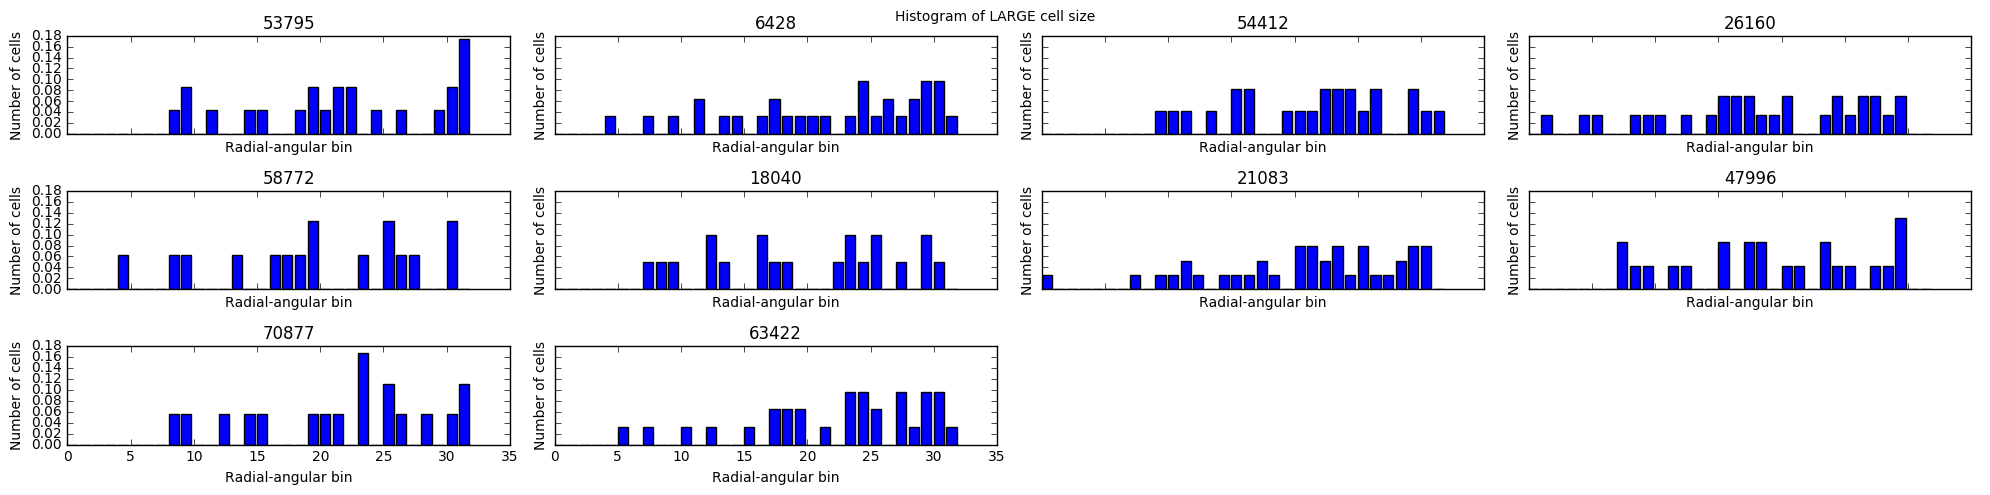

# Regional features

In [36]:
image = load_cell_data('image', stack=stack, sections=[section_to_analyze])[section_to_analyze]

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/PIL/Image.py:2246: DecompressionBombWarning: Image size (185246720 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [22]:
contour_df, _ = DataManager.load_annotation_v3(stack=stack, annotation_rootdir=annotation_midbrainIncluded_v2_rootdir)
contours = {cnt['name']: cnt['vertices'] for cnt_id, cnt in contour_df[contour_df['section'] == section_to_analyze].iterrows()}

'No object named structures in the file'


Annotation has no structures.


In [37]:
contours.keys()

['7n', 'RMC', '7N', 'SC', 'IC', 'Pn']

In [148]:
# For visualization

cell_contours = load_cell_data('contours', stack=stack, sections=[section_to_analyze])[section_to_analyze]
cell_mask_centers = load_cell_data('mask_center', stack=stack, sections=[section_to_analyze])[section_to_analyze]
cell_contours_global = {i: cell_centroids_per_section[section_to_analyze][i].astype(np.int) - cell_mask_centers[i] + cell_contours[i]
                        for i in range(cell_numbers_per_section[section_to_analyze])}

# Compute histograms

In [290]:
all_cell_size_histogram_all_regions = {}
all_cell_size_weighted_histogram_all_regions = {}
large_cell_size_histogram_all_regions = {}

large_cell_orientation_histogram_all_regions = {}

neighbor_distance_histogram_all_regions = {}
neighbor_direction_histogram_all_regions = {}

large_cell_graph_neighbor_distance_histogram_all_regions = {}
large_cell_graph_neighbor_direction_histogram_all_regions = {}

large_small_cell_graph_neighbor_distance_histogram_all_regions = {}
large_small_cell_graph_neighbor_direction_histogram_all_regions = {}

In [306]:
#######################################################
# Identify large and small cells
######################################################

large_cell_indices_this_section = large_cell_indices_per_section[section_to_analyze]
large_cell_centroids_this_section = cell_centroids_per_section[section_to_analyze][large_cell_indices_this_section]

for name_u, cnt in contours.iteritems():
# for name_u, cnt in [('7N', contours['7N'])]:
# name_u = '7N'
# cnt = contours[name_u]

    n = len(cnt)
    fn = sections_to_filenames[section_to_analyze]
    vertices_on_aligned = np.dot(Ts_inv_downsampled[fn], np.c_[cnt/downsample_factor, np.ones((n,))].T).T[:, :2]

    xs = vertices_on_aligned[:,0] - crop_xmin * 32 / downsample_factor
    ys = vertices_on_aligned[:,1] - crop_ymin * 32 / downsample_factor

    cnt_cropped = np.c_[xs, ys].astype(np.int)

    # Get large cells

    # from shapely.geometry import Polygon
    from matplotlib.path import Path

    large_cell_is_inside = Path(cnt_cropped.astype(np.int)).contains_points(large_cell_centroids_this_section)
    large_cell_indices_inside = large_cell_indices_this_section[large_cell_is_inside]

    print '%d large cells are identified in %s.' % (len(large_cell_indices_inside), name_u)

    # Small cells

    small_cell_indices_this_section = np.array(list(set(range(cell_numbers_per_section[section_to_analyze])) - set(large_cell_indices_this_section.tolist())))
    small_cell_centroids_this_section = cell_centroids_per_section[section_to_analyze][small_cell_indices_this_section]
    small_cell_is_inside = Path(cnt_cropped.astype(np.int)).contains_points(small_cell_centroids_this_section)
    small_cell_indices_inside = small_cell_indices_this_section[small_cell_is_inside]

    print '%d small cells are identified in %s.' % (len(small_cell_indices_inside), name_u)

    ##############################
    # Visualize
    ##############################

#     viz = image.copy()

#     for i in large_cell_indices_inside:
#         cv2.polylines(viz, [cell_contours_global[i].astype(np.int)], isClosed=True, color=(255,0,0), thickness=1)

#     for i in small_cell_indices_inside:
#         cv2.polylines(viz, [cell_contours_global[i].astype(np.int)], isClosed=True, color=(0,255,0), thickness=1)

#     cv2.polylines(viz, [cnt_cropped.astype(np.int)], isClosed=True, color=(0,0,255), thickness=1)

#     # Visualize radial-angular histogram of selected cells

#     # for source in large_cell_indices_inside:
#     for source in large_cell_indices_inside[50:51]:
#         for i in neighbors[source]:

#             if i in large_cell_indices_inside:
#                 cv2.circle(viz, tuple(cell_centroids_per_section[section_to_analyze][i].astype(np.int)), 3, color=(255,0,0), thickness=-1)

#                 cv2.line(viz, tuple(cell_centroids_per_section[section_to_analyze][source].astype(np.int)), 
#                      tuple(cell_centroids_per_section[section_to_analyze][i].astype(np.int)), 
#                      color=(255,0,0), thickness=1)


#             if i in small_cell_indices_inside:
#                 cv2.circle(viz, tuple(cell_centroids_per_section[section_to_analyze][i].astype(np.int)), 3, color=(0,255,0), thickness=-1)            

#                 cv2.line(viz, tuple(cell_centroids_per_section[section_to_analyze][source].astype(np.int)), 
#                          tuple(cell_centroids_per_section[section_to_analyze][i].astype(np.int)), 
#                          color=(0,255,0), thickness=1)


#         # draw radial bins
#         for rb in radial_bins:
#             cv2.circle(viz, tuple(cell_centroids_per_section[section_to_analyze][source].astype(np.int)), 
#                       int(rb), color=(0,0,255), thickness=1)

#         # draw angular bins
#         for ab in angular_bins:
#             cv2.line(viz, tuple(cell_centroids_per_section[section_to_analyze][source].astype(np.int)), 
#                      tuple((cell_centroids_per_section[section_to_analyze][source] + (np.cos(ab)*100, np.sin(ab)*100)).astype(np.int)),
#              color=(0,0,255), thickness=1)

#     # Find crop box

#     margin = 50
#     roi_xmin, roi_ymin = cnt_cropped.astype(np.int).min(axis=0) - margin
#     roi_xmax, roi_ymax = cnt_cropped.astype(np.int).max(axis=0) + margin
#     print roi_xmin, roi_xmax, roi_ymin, roi_ymax

#     display_image(viz[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1])

    #################################
    # Compute cell size distribution
    #################################

    size_bins = np.r_[np.linspace(0, 3000, 10), np.inf]

    large_cell_size_inside_histogram, _ = np.histogram([cell_sizes_per_section[section_to_analyze][i] for i in large_cell_indices_inside], bins=size_bins)
#     print 'large_cell_size_inside_histogram:', large_cell_size_inside_histogram
    large_cell_size_histogram_all_regions[name_u] = large_cell_size_inside_histogram

    all_cell_size_inside_histogram, _ = np.histogram([cell_sizes_per_section[section_to_analyze][i] for i in np.r_[large_cell_indices_inside, small_cell_indices_inside]], 
                                           bins=size_bins)
    #     print 'all_cell_size_inside_histogram:', all_cell_size_inside_histogram
    all_cell_size_histogram_all_regions[name_u] = all_cell_size_inside_histogram    

    
    all_cell_size_weighted_inside_histogram, _ = np.histogram([cell_sizes_per_section[section_to_analyze][i] for i in np.r_[large_cell_indices_inside, small_cell_indices_inside]], 
                                       bins=size_bins, 
                                                 weights=[cell_sizes_per_section[section_to_analyze][i] for i in np.r_[large_cell_indices_inside, small_cell_indices_inside]])
    all_cell_size_weighted_histogram_all_regions[name_u] = all_cell_size_weighted_inside_histogram    

    
    #########################################
    # Compute cell orientation distribution
    #########################################
    
    n_orientation_bins = 10
    orientation_bins = np.linspace(-np.pi/2, np.pi/2, n_orientation_bins+1)

    large_cell_orientation_inside_histogram, _ = np.histogram([cell_orientations_per_section[section_to_analyze][i] for i in large_cell_indices_inside], bins=orientation_bins)
#     print 'large_cell_orientation_inside_histogram:', large_cell_orientation_inside_histogram

    large_cell_orientation_histogram_all_regions[name_u] = large_cell_orientation_inside_histogram
    
    ##########################################
    # Construct graph
    # Start from large cells, link to all cells
    ##########################################

    import networkx as nx
    g = nx.Graph()

    for source_sectionwise_idx in large_cell_indices_inside:

        neighbor_masks = np.array([cell_masks_aligned_padded_flattened_per_section[section_to_analyze][i_sectionwise_idx]
                          for i_sectionwise_idx in neighbors[source_sectionwise_idx]])

        jacs, _ = compute_jaccard_x_vs_list(cell_masks_aligned_padded_flattened_per_section[section_to_analyze][source_sectionwise_idx], 
                                        neighbor_masks,
                                        x_h=cell_masks_aligned_padded_horizontal_flattened_per_section[section_to_analyze][source_sectionwise_idx],
                                         x_v=cell_masks_aligned_padded_vertical_flattened_per_section[section_to_analyze][source_sectionwise_idx],
                                         x_d=cell_masks_aligned_padded_diagonal_flattened_per_section[section_to_analyze][source_sectionwise_idx])

        for i_sectionwise_idx, vec, jac in zip(neighbors[source_sectionwise_idx], neighbor_vectors[source_sectionwise_idx], jacs):
            length = np.sqrt(np.sum(vec**2))
            direction = np.arctan2(vec[1], vec[0])
            
            # Force into between -np.pi/2 and np.pi/2
            if direction > np.pi/2:
                direction = direction - np.pi
            elif direction < -np.pi/2:
                direction = direction + np.pi
            
            orientation_diff = np.abs(cell_orientations_per_section[section_to_analyze][source_sectionwise_idx] - cell_orientations_per_section[section_to_analyze][i_sectionwise_idx])
            size_diff = np.abs(cell_sizes_per_section[section_to_analyze][source_sectionwise_idx] - cell_sizes_per_section[section_to_analyze][i_sectionwise_idx])

            g.add_edge(source_sectionwise_idx, i_sectionwise_idx, weight=1, length=length, direction=direction, 
                       orientation_diff=orientation_diff,
                      size_diff=size_diff,
                      jaccard=jac)

    ##########################################
    # Collect edge attributes
    ##########################################

    all_edge_length = []
    all_edge_direction = []
    for u, v in g.edges_iter():
    #     print u, v
        ed = g.get_edge_data(u, v)
        all_edge_length.append(ed['length'])
        all_edge_direction.append(ed['direction'])

    ##########################################
    # Compute neighbor distance histogram
    ##########################################

#     print 'min', np.min(all_edge_length), 'max', np.max(all_edge_length)

    n_edge_length_bins = 10
    edge_length_bins = np.r_[np.linspace(0, 100, n_edge_length_bins), np.inf]
    edge_length_histogram, _ = np.histogram(all_edge_length, bins=edge_length_bins)

    neighbor_distance_histogram_all_regions[name_u] = edge_length_histogram

    ##########################################
    # Compute neighbor direction histogram
    ##########################################

    n_edge_direction_bins = 10
    edge_direction_bins = np.linspace(-np.pi/2, np.pi/2, n_edge_direction_bins+1)
    edge_direction_histogram, _ = np.histogram(all_edge_direction, bins=edge_direction_bins)
    
    neighbor_direction_histogram_all_regions[name_u] = edge_direction_histogram

    ################################
    # Subgraph between large cells.
    ################################

    large_cell_subgraph = g.subgraph(large_cell_indices_inside)
        
    all_large_cell_graph_edge_length = []
    all_large_cell_graph_edge_direction = []
    for u, v in large_cell_subgraph.edges_iter():
        ed = large_cell_subgraph.get_edge_data(u, v)
        all_large_cell_graph_edge_length.append(ed['length'])
        all_large_cell_graph_edge_direction.append(ed['direction'])
        
    ##########################################
    # Compute neighbor distance histogram
    ##########################################

#     print 'min', np.min(all_edge_length), 'max', np.max(all_edge_length)

    edge_length_histogram, _ = np.histogram(all_large_cell_graph_edge_length, bins=edge_length_bins)
    large_cell_graph_neighbor_distance_histogram_all_regions[name_u] = edge_length_histogram

    ##########################################
    # Compute neighbor direction histogram
    ##########################################

    edge_direction_histogram, _ = np.histogram(all_large_cell_graph_edge_direction, bins=edge_direction_bins)
    large_cell_graph_neighbor_direction_histogram_all_regions[name_u] = edge_direction_histogram
    
    
    ##########################################
    # Large/small cells graph
    ##########################################

    all_large_small_cell_graph_edge_length = []
    all_large_small_cell_graph_edge_direction = []

    for u, v in g.edges_iter():
        if (u in large_cell_indices_inside and v in small_cell_indices_inside) or \
        (v in large_cell_indices_inside and u in small_cell_indices_inside):
            ed = g.get_edge_data(u,v)
            all_large_small_cell_graph_edge_length.append(ed['length'])
            all_large_small_cell_graph_edge_direction.append(ed['direction'])

    edge_length_histogram, _ = np.histogram(all_large_small_cell_graph_edge_length, bins=edge_length_bins)
    large_small_cell_graph_neighbor_distance_histogram_all_regions[name_u] = edge_length_histogram

    edge_direction_histogram, _ = np.histogram(all_large_small_cell_graph_edge_direction, bins=edge_direction_bins)
    large_small_cell_graph_neighbor_direction_histogram_all_regions[name_u] = edge_direction_histogram

1 large cells are identified in 7n.
31 small cells are identified in 7n.
46 large cells are identified in RMC.
121 small cells are identified in RMC.
153 large cells are identified in 7N.
291 small cells are identified in 7N.
2668 large cells are identified in SC.
5552 small cells are identified in SC.
907 large cells are identified in IC.
1587 small cells are identified in IC.
447 large cells are identified in Pn.
464 small cells are identified in Pn.


# Plot histograms

In [307]:
def plot_histograms(hists, bins, titles=None, ncols=4, xlabel='', ylabel='', suptitle=''):
    
    if isinstance(hists, dict):
        titles = hists.keys()
        hists = hists.values()
    
    n = len(hists)
    nrows = int(np.ceil(n/float(ncols)))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,5), sharex=True, sharey=True)
    axes = axes.flatten()
    
    width = np.abs(np.mean(np.diff(bins)))*.8

    c = 0
    for name_u, h in zip(titles, hists):

        axes[c].bar(bins, h/float(h.sum()), width=width); 
        axes[c].set_xlabel(xlabel);
        axes[c].set_ylabel(ylabel);
        axes[c].set_title(name_u);
        c += 1

    for i in range(c, len(axes)):
        axes[i].axis('off')

    plt.suptitle(suptitle);
    plt.tight_layout();
    plt.show()

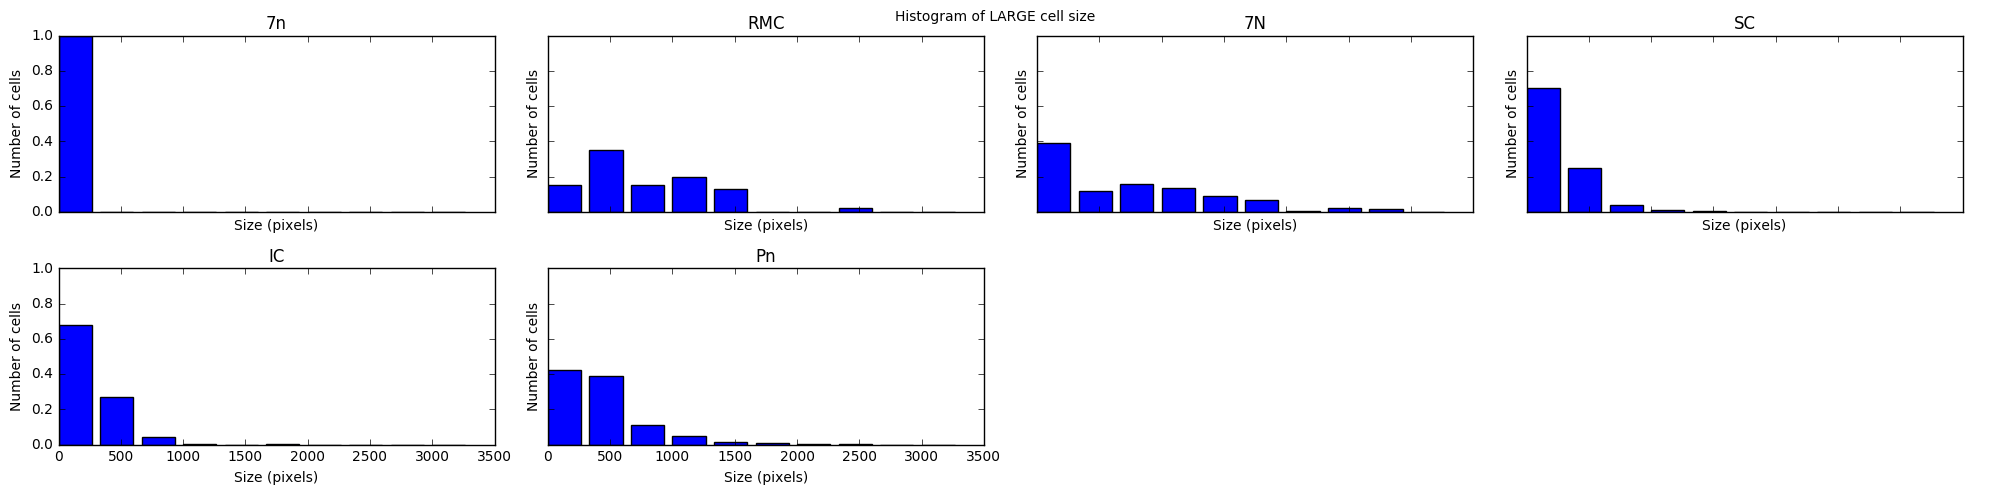

In [308]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in large_cell_size_histogram_all_regions.iteritems()},
                bins=size_bins[:-1],
               xlabel='Size (pixels)', 
                ylabel='Number of cells',
               suptitle='Histogram of LARGE cell size')

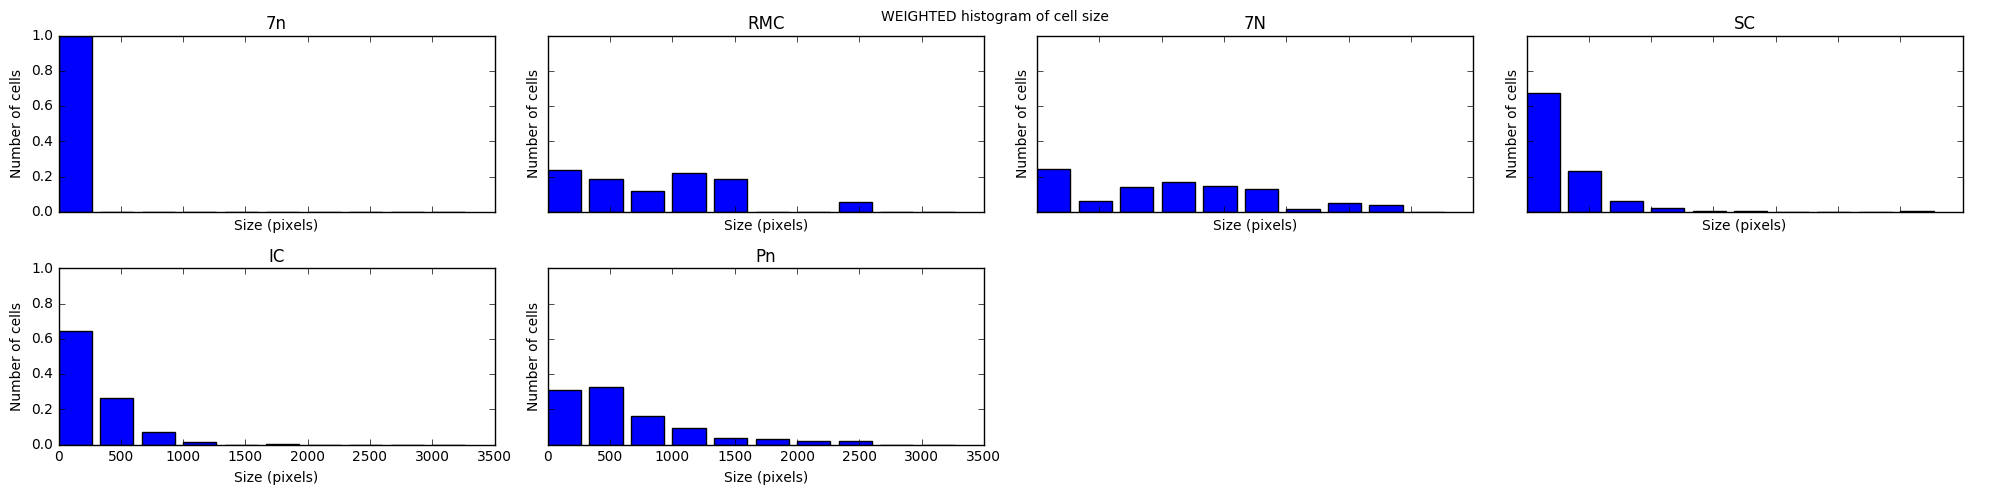

In [309]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in all_cell_size_weighted_histogram_all_regions.iteritems()},
                bins=size_bins[:-1],
               xlabel='Size (pixels)', 
                ylabel='Number of cells',
               suptitle='WEIGHTED histogram of cell size')

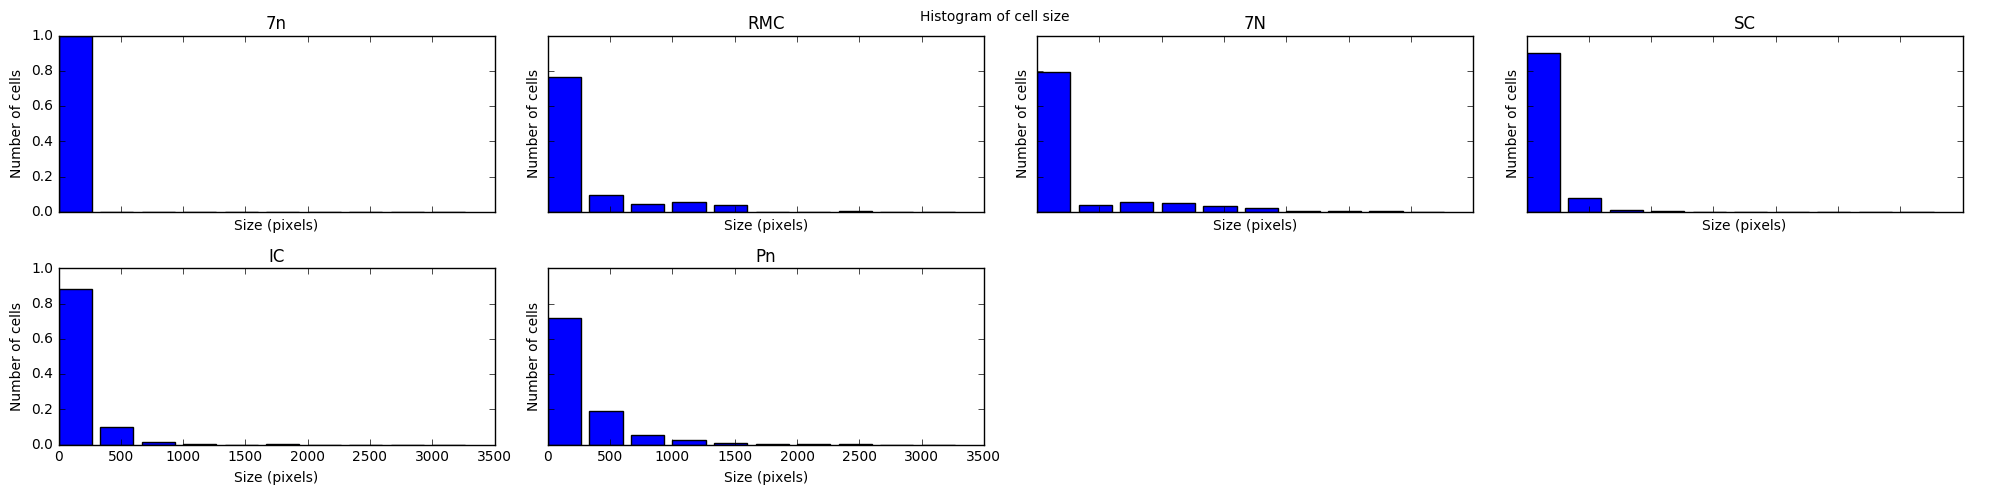

In [310]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in all_cell_size_histogram_all_regions.iteritems()},
                bins=size_bins[:-1],
               xlabel='Size (pixels)', 
                ylabel='Number of cells',
               suptitle='Histogram of cell size')

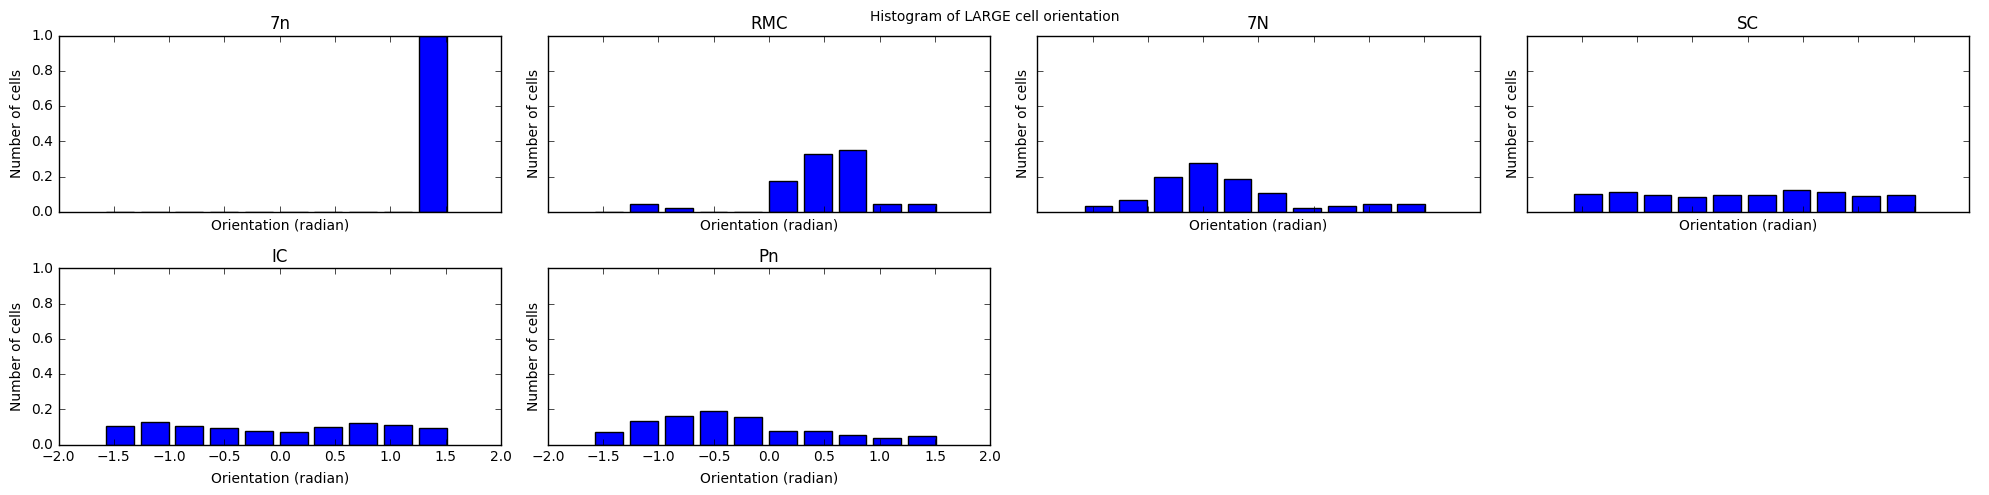

In [311]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in large_cell_orientation_histogram_all_regions.iteritems()},
                bins=orientation_bins[:-1],
               xlabel='Orientation (radian)', 
                ylabel='Number of cells',
               suptitle='Histogram of LARGE cell orientation')

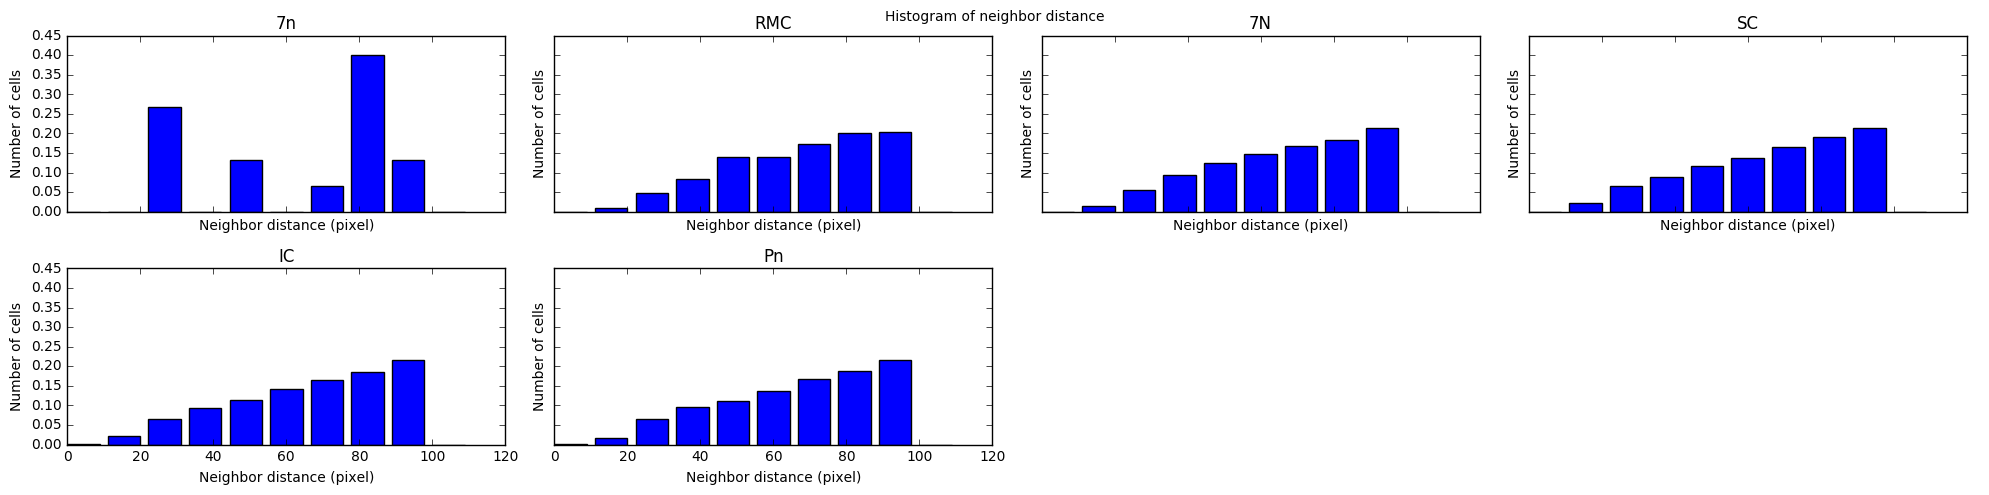

In [312]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in neighbor_distance_histogram_all_regions.iteritems()},
                bins=edge_length_bins[:-1],
               xlabel='Neighbor distance (pixel)', 
                ylabel='Number of cells',
               suptitle='Histogram of neighbor distance')

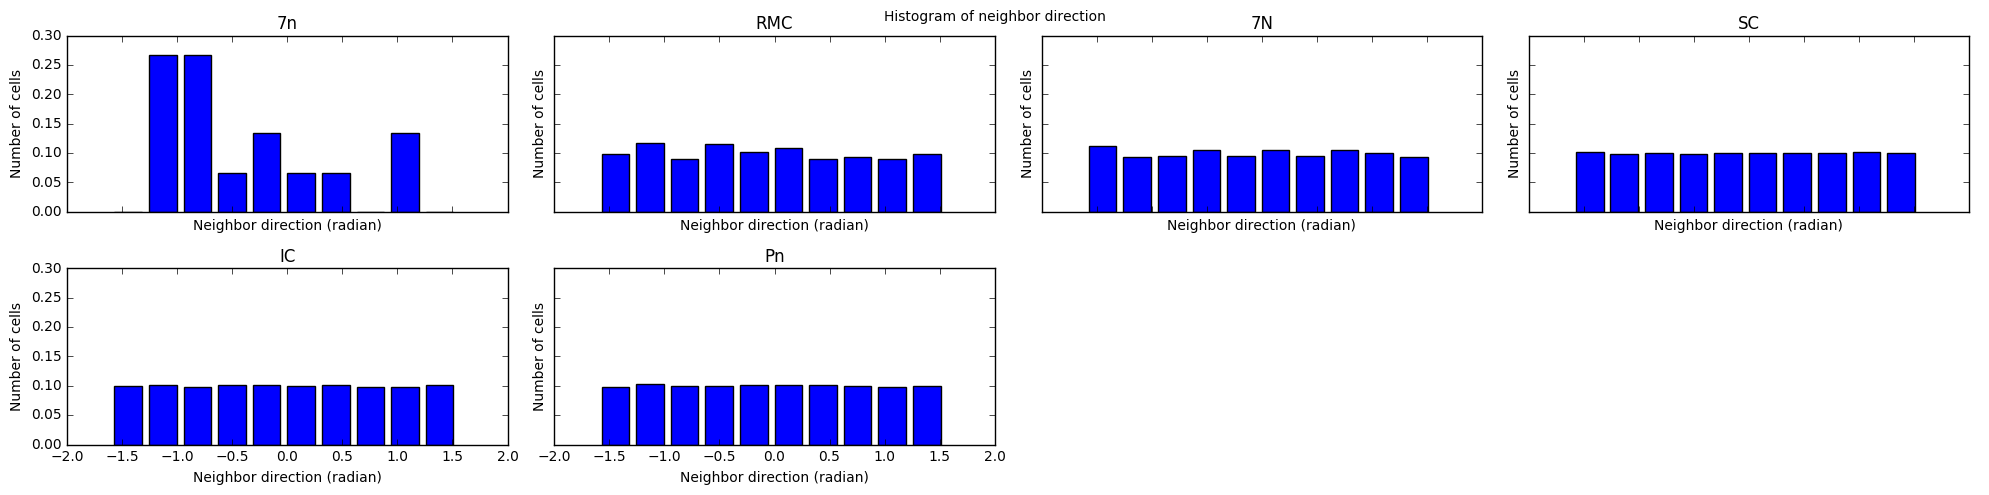

In [313]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in neighbor_direction_histogram_all_regions.iteritems()},
                bins=edge_direction_bins[:-1],
               xlabel='Neighbor direction (radian)', 
                ylabel='Number of cells',
               suptitle='Histogram of neighbor direction')

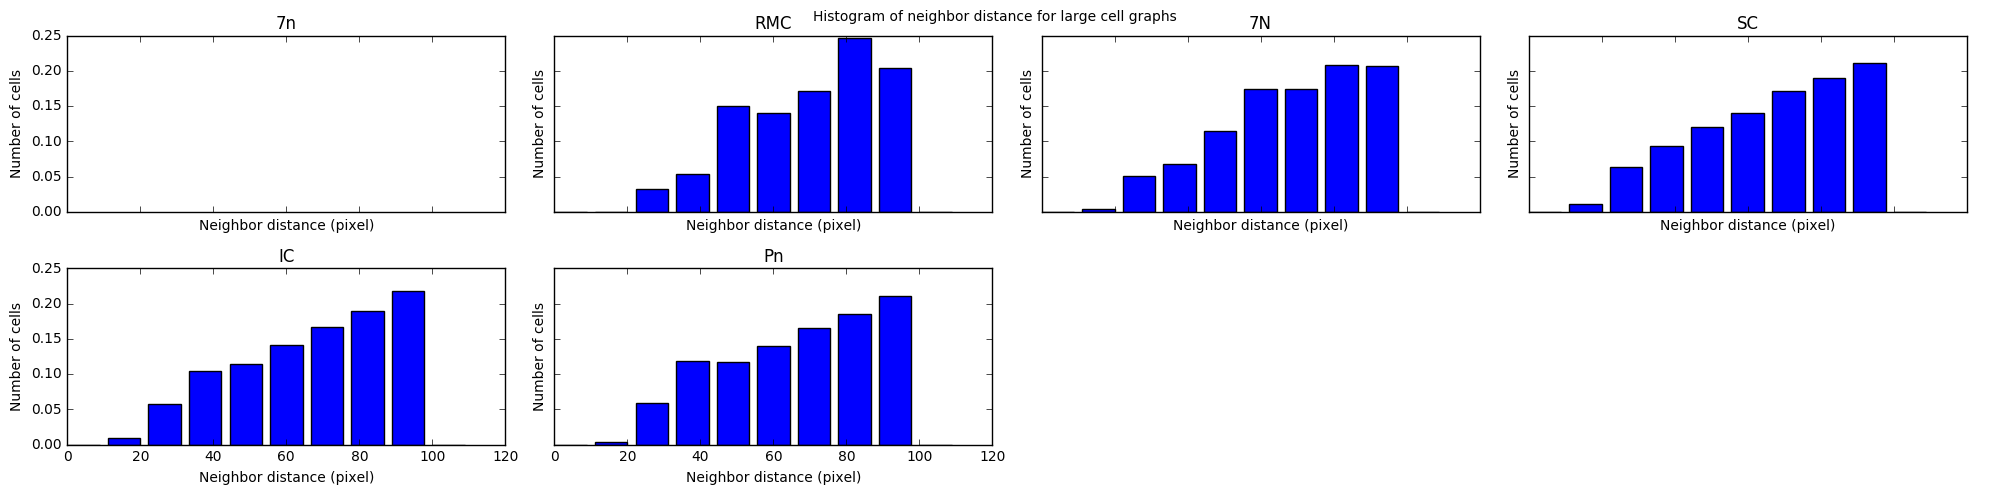

In [314]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in large_cell_graph_neighbor_distance_histogram_all_regions.iteritems()},
                bins=edge_length_bins[:-1],
               xlabel='Neighbor distance (pixel)', 
                ylabel='Number of cells',
               suptitle='Histogram of neighbor distance for large cell graphs')

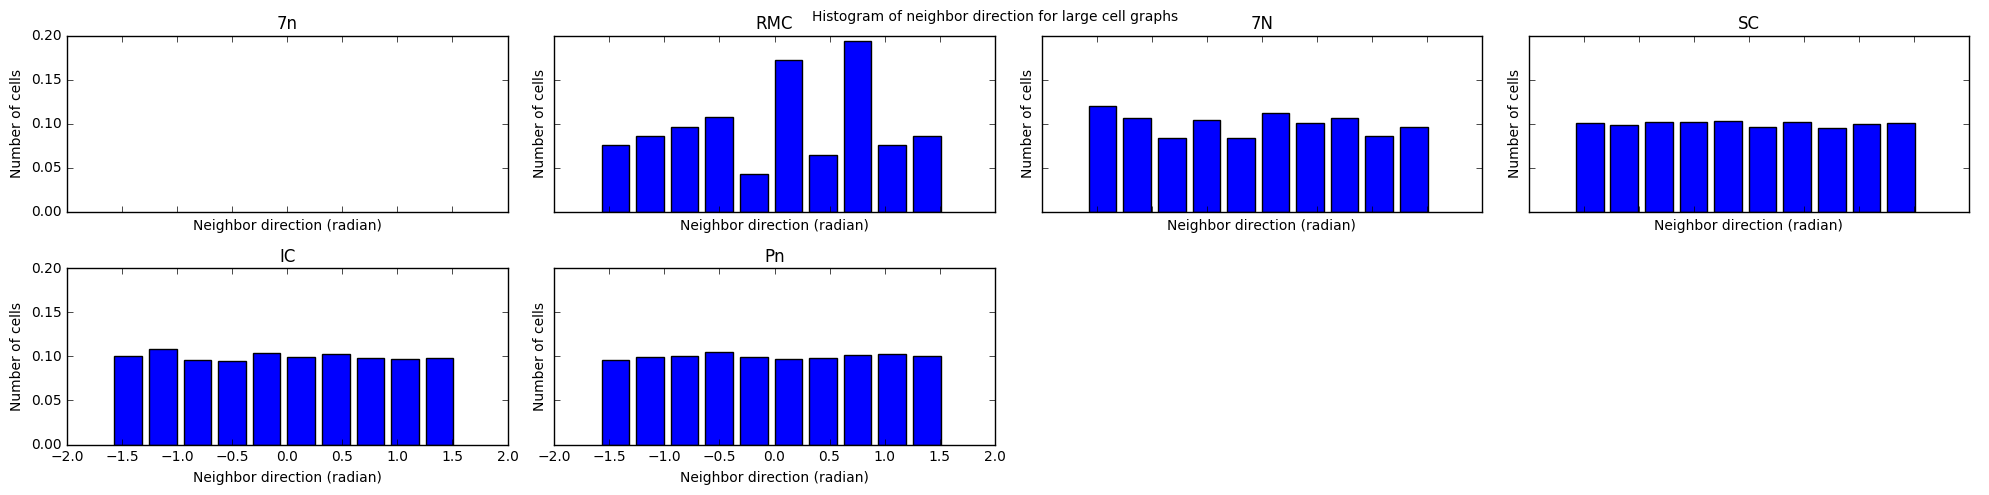

In [315]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in large_cell_graph_neighbor_direction_histogram_all_regions.iteritems()},
                bins=edge_direction_bins[:-1],
               xlabel='Neighbor direction (radian)', 
                ylabel='Number of cells',
               suptitle='Histogram of neighbor direction for large cell graphs')

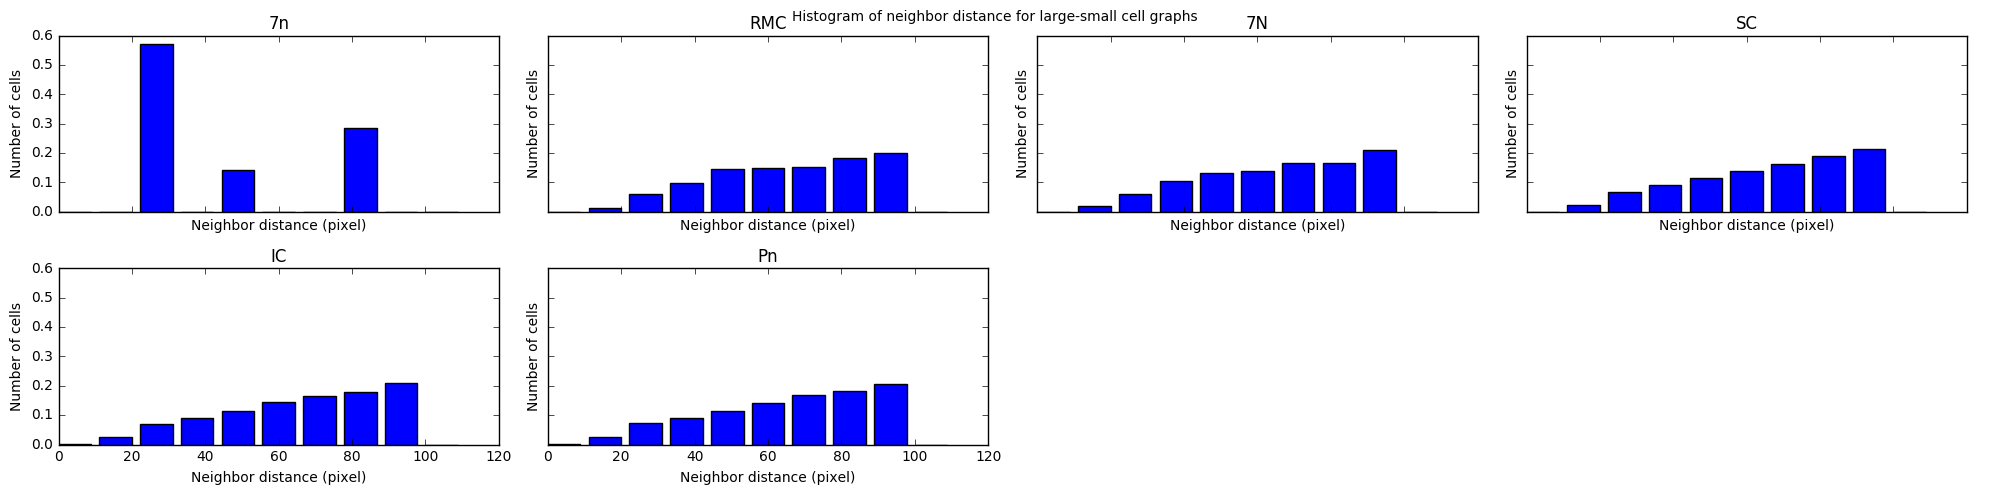

In [316]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in large_small_cell_graph_neighbor_distance_histogram_all_regions.iteritems()},
                bins=edge_length_bins[:-1],
               xlabel='Neighbor distance (pixel)', 
                ylabel='Number of cells',
               suptitle='Histogram of neighbor distance for large-small cell graphs')

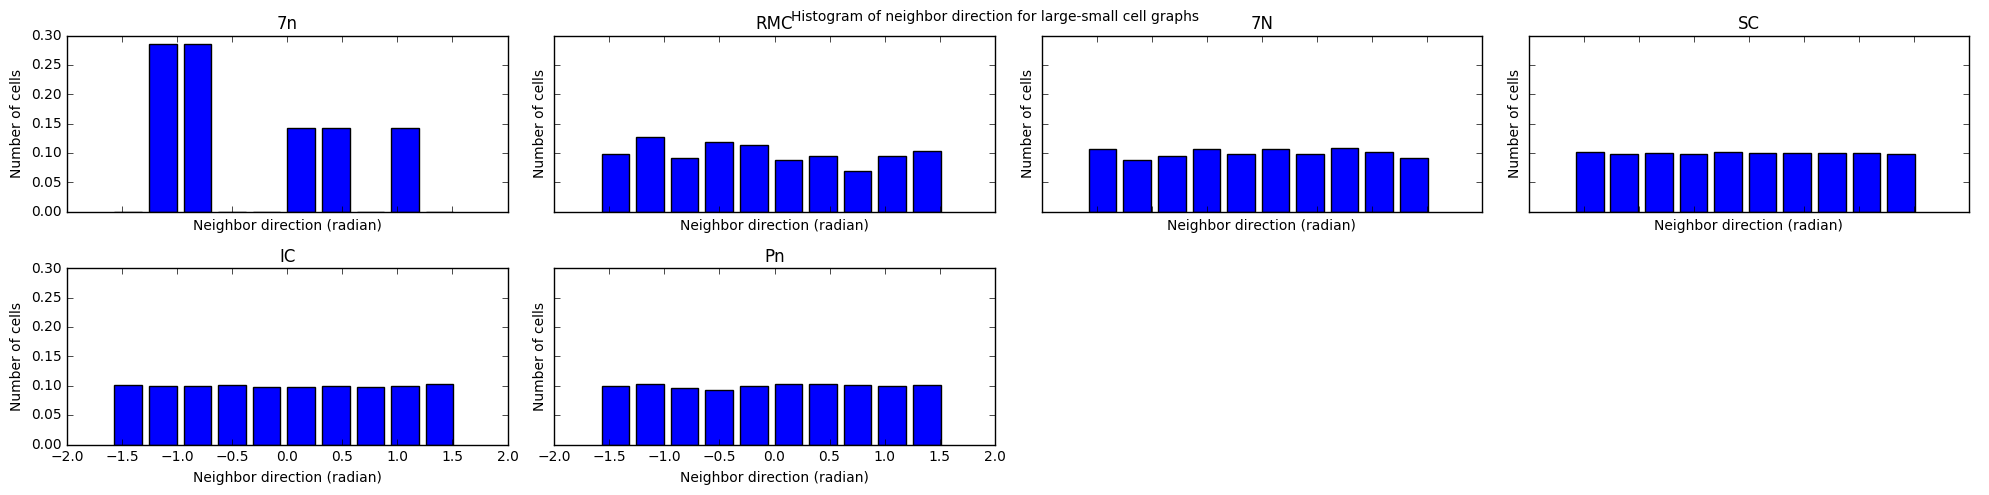

In [317]:
plot_histograms({name_u: h/float(h.sum()) for name_u, h in large_small_cell_graph_neighbor_direction_histogram_all_regions.iteritems()},
                bins=edge_direction_bins[:-1],
               xlabel='Neighbor direction (radian)', 
                ylabel='Number of cells',
               suptitle='Histogram of neighbor direction for large-small cell graphs')

In [85]:
# composite_bin_indices = [r * n_angular + a for r, a in zip(radial_indices, angular_indices)]

# n_composite_bins = n_radial * n_angular

# histogram = np.bincount(composite_bin_indices, minlength=n_composite_bins)
# histogram = histogram/float(histogram.sum())

# plt.bar(range(n_composite_bins), histogram);
# plt.ylabel('density');
# plt.xlabel('bins');
# plt.show();